# Run one sample correlation test

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
import itertools
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [4]:
data_path = '/data_volume/ifn_hbec/'
fig_path = '/home/ssm-user/Github/scrna-parameter-estimation/figures/fig5/main/'

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [5]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

In [6]:
adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [7]:
adata.shape

(69958, 36588)

### Setup memento

In [8]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [9]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [10]:
memento.setup_memento(adata, q_column='q', trim_percent=0.1)

### Define TFs

In [11]:
filtered_tfs = """MAFG
SPI1
ZNF655
MAX
ATF4
ATF3
IRF2
IRF1
ARID5A
BACH1
YY1
HMGA1
IRF7
STAT1
NR1H2
XBP1
ETV6
MSC
ATF5
MAFB
FOS
CEBPB
BBX
STAT3
REL
JUN
CEBPD
DDIT3
NR3C1
TGIF1
ZNF267
NFE2L2
HIF1A
AHR
GTF2B
CREM
HBP1
RELB
TFEC
YBX1
ELF1
JUNB
NFKB1
IRF9
RBPJ
KLF6""".split()

### One sample test for all TFs

In [12]:
adata_ctrl = adata.copy()[
    adata.obs.cell_type.isin(['ciliated']) & \
    adata.obs.stim.isin(['control']), :].copy()

In [13]:
memento.create_groups(adata_ctrl, label_columns=['donor'])

In [14]:
memento.compute_1d_moments(adata_ctrl, min_perc_group=.9)

In [ ]:
for tf in filtered_tfs:
    
    if tf not in adata_ctrl.var.index.tolist():
        continue
    
    print('Control correlations for:', tf)
    
    memento.compute_2d_moments(adata_ctrl, list(itertools.product([tf], adata_ctrl.var.index.tolist())))
    
    memento.ht_2d_moments( 
        adata_ctrl, 
        formula_like='1',
        cov_column='Inter', 
        num_boot=10000, 
        verbose=1,
        num_cpus=14)
    
    adata_ctrl.write(data_path + 'control_corr/{}.h5ad'.format(tf))

### Get number of significantly correlated genes for each TF

In [17]:
tf_list = list(set(filtered_tfs) & set(adata_ctrl.var.index))

In [205]:
output_dfs = {}
for tf in tf_list:
    
    adata_tf = sc.read(data_path + 'control_corr/{}.h5ad'.format(tf))
    tf_result = memento.get_2d_ht_result(adata_tf)
    tf_result['corr_fdr'] = memento.util._fdrcorrect(tf_result['corr_pval'])
#     tf_result = tf_result.query('~gene_2.str.contains("RPS") & ~gene_2.str.contains("RPL")', engine='python')
    output_dfs[tf] = tf_result

### Volcano plots for STAT1, IRF7

In [242]:
def tf_volcano(tf):
    tf_result = output_dfs[tf]
    tf_result['logp'] = -np.log10(tf_result['corr_pval'])
    plt.scatter(tf_result['corr_coef'],tf_result['logp'], s=0.1, color='grey')
    plt.scatter(
        tf_result.query('corr_fdr < 0.1')['corr_coef'],
        tf_result.query('corr_fdr < 0.1')['logp'], s=1.2)
    plt.title(tf); plt.ylabel('log P-value'); plt.xlabel('correlation')
    
    return tf_result

<ipython-input-249-ea4b46031afd>:7: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fig_path + 'tf_volcano.png', bbox_to_inches='tight', dpi=300)


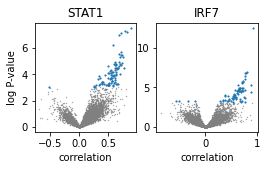

In [249]:
plt.figure(figsize=(4,2))
plt.subplot(1, 2, 1);
stat1_df = tf_volcano('STAT1')
plt.subplot(1, 2, 2)
irf7_df = tf_volcano('IRF7')
plt.ylabel(None)
plt.savefig(fig_path + 'tf_volcano.png', bbox_to_inches='tight', dpi=300)

In [250]:
irf7_df.sort_values('logp', ascending=False).head(20)

,gene_1,gene_2,corr_coef,corr_se,corr_pval,corr_fdr,logp
9583,IRF7,MX1,0.917227,0.060723,2.976680e-13,3.020735e-09,12.526268
6581,IRF7,EPSTI1,0.798548,0.083384,1.135444e-07,3.909930e-04,6.944834
2538,IRF7,HERC6,0.767718,0.104611,1.314186e-07,3.909930e-04,6.881343
5206,IRF7,IFIT1,0.781096,0.085885,1.541163e-07,3.909930e-04,6.812152
9582,IRF7,MX2,0.754638,0.087823,3.618774e-07,7.344663e-04,6.441439
4,IRF7,ISG15,0.751050,0.073313,7.585380e-07,1.282941e-03,6.120023
462,IRF7,IFI44L,0.712595,0.086325,1.781597e-06,2.283974e-03,5.749191
6406,IRF7,OAS1,0.697910,0.107587,1.917242e-06,2.283974e-03,5.717323
5388,IRF7,IFITM3,0.724710,0.074521,2.025598e-06,2.283974e-03,5.693447
203,IRF7,IFI6,0.697548,0.064869,2.521014e-06,2.558325e-03,5.598425


In [247]:
stat1_df.sort_values('logp', ascending=False).head(20)

,gene_1,gene_2,corr_coef,corr_se,corr_pval,corr_fdr,logp
6408,STAT1,OAS2,0.901655,0.077944,2.915865e-08,0.000167,7.535233
9582,STAT1,MX2,0.793511,0.092598,4.625450e-08,0.000167,7.334846
9583,STAT1,MX1,0.824872,0.060023,5.667139e-08,0.000167,7.246636
7907,STAT1,XAF1,0.727158,0.092976,6.571431e-08,0.000167,7.182340
3984,STAT1,SAMD9L,0.679193,0.097797,9.592675e-08,0.000195,7.018060
203,STAT1,IFI6,0.581431,0.067933,5.292960e-07,0.000895,6.276301
463,STAT1,IFI44,0.717163,0.096622,1.965733e-06,0.002850,5.706476
8155,STAT1,IFI35,0.682694,0.093186,3.041137e-06,0.003630,5.516964
6407,STAT1,OAS3,0.733548,0.101393,3.457292e-06,0.003630,5.461264
5387,STAT1,IFITM1,0.725632,0.080260,3.576697e-06,0.003630,5.446518


In [224]:
tf_result = output_dfs['IRF7']
tf_result['logp'] = -np.log(tf_result['corr_pval'])

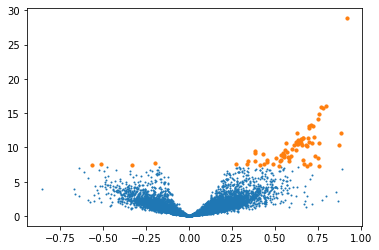

In [226]:
plt.scatter(tf_result['corr_coef'],tf_result['logp'], s=1)
plt.scatter(
    tf_result.query('corr_fdr < 0.1')['corr_coef'],
    tf_result.query('corr_fdr < 0.1')['logp'], s=10)